In [332]:
import numpy as np
import copy
from matplotlib import pyplot as plt

In [481]:
def underlying(n):
    
    # Initialize underlying price data for this problem
    # input:
    # n: number of weeks
    # output:
    # S: underlying price
    
    S = np.zeros((n*2-1,n))
    for j in range(np.shape(S)[1]):
        jiou = ((j % 2) == 0)
        for i in range(np.shape(S)[0]):
            k = (np.shape(S)[0]-1)/2 - i
            if abs(k)<=j and (((abs(k) % 2) == 0) == jiou):
                S[i,j] = 1.1 ** k
    return S

S = underlying(53)

In [482]:
def one(S,p,K,ud):
    
    # Calculate 1-up/down swing
    # input:
    # S: underlying price
    # K: Strike price
    # ud: "up" or "down"
    # output:
    # One: 1-up/down swing
    # E: Exercise or not at each node
    
    E = np.zeros(np.shape(S))
    One = np.zeros(np.shape(S))
    if ud == "up":
        One[:,-1] = np.maximum((S[:,-1] - K),np.zeros(np.shape(S)[0])) * np.float32(S[:,-1]!= 0)
    if ud == "down":
        One[:,-1] = np.maximum((K - S[:,-1]),np.zeros(np.shape(S)[0])) * np.float32(S[:,-1]!= 0)
    
    E[:,-1] = np.float32(One[:,-1]!= 0)
    
    for j in range(np.shape(S)[1]-2,-1,-1):
        for i in range(np.shape(S)[0]):
            if S[i,j]!=0:
                u = One[i-1,j+1]
                d = One[i+1,j+1]
                f = u * p + d * (1 - p)
                if ud == "up":
                    e = max(S[i,j] - K,0)
                if ud == "down":
                    e = max(K - S[i,j],0)
                if e >= f and e - f > 0.0001*f:
                    One[i,j] = e
                    E[i,j] = 1
                else:
                    One[i,j] = f
    
    return One,E



In [483]:
def add_one(S,X,E,p,K,ud):
    
    # Calculate k+1-up/down swing
    # input:
    # S: underlying price
    # X: k-up/down swing
    # p: probability of going up
    # K: strike price
    # E: Exercise or not at each node
    # ud: "up" or "down"
    # output:
    # Y: k+1-up/down swing
    # E1: Exercise or not at each node
    
    Y = copy.deepcopy(X)
    E1 = copy.deepcopy(E)
    for j in range(np.shape(Y)[1]-2,-1,-1):
        for i in range(np.shape(S)[0]):
            if S[i,j]!=0:
                f = Y[i-1,j+1] * p + Y[i+1,j+1] * (1 - p)
                fk = X[i,j]
                if ud == "up":
                    e = max(S[i,j] - K,0)
                if ud == "down":
                    e = max(K - S[i,j],0)
                if (e + fk) > f and e+fk-f > 0.0001*f and E[i,j] != 1:
                    Y[i,j] = e + fk
                    E1[i,j] = 1
                else:
                    Y[i,j] = max(f,fk)
    
    return Y,E1

In [500]:
def plottree(E):
    
    # Plot the decision tree with optimal nodes
    # input:
    # U: decision tree in matrix form
    # E: exercised nodes in matrix
    size1 = np.shape(E)[0]
    size2 = np.shape(E)[1]
    fig = plt.figure(figsize=[size1/5, size2/5])
    
    for i in range(size2-1):
        x = [1, 0, 1]
        for j in range(i):
            x.append(0)
            x.append(1)
        x = np.array(x) + i
        y = np.arange(-(i+1), i+2)[::-1]
        
        plt.plot(x, y, 'ko-', linewidth=0.7)
        
        kx = []
        ky = []
        for k in range(len(y)):
            if E[size2-1-y[k],x[k]] == 1:
                kx.append(x[k])
                ky.append(y[k])
        plt.plot(kx, ky, "ro")
                
        
    plt.yticks([-50, -30, -15, 0, 15, 30, 50],
       [r'$1.1^{-50}$', r'$1.1^{-30}$', r'$1.1^{-15}$', 
        r'$1.1^{0}$',r'$1.1^{15}$', r'$1.1^{30}$', r'$1.1^{50}$'])
    plt.xlabel("Weeks", fontsize=20)
    plt.ylabel("Gasoline price", fontsize=20)
    plt.title("Option Tree with optimal exercise nodes (in red)", fontsize=30)
    
    

In [503]:
def main():
    p = (1-1.1**(-1))/(1.1-1.1**(-1))
    
    D1,ED1 = one(S,p,1,"down")
    VD1 = D1[52,0]

    U1,EU1 = one(S,p,1, "up")
    VU1 = U1[52,0]

    D2,ED2 = add_one(S,D1,ED1,p,1,"down")
    VD2 = D2[52,0]

    U2,EU2 = add_one(S,U1,EU1,p,1,"up")
    VU2 = U2[52,0]

    D3,ED3 = add_one(S,D2,ED2,p,1,"down")
    VD3 = D3[52,0]

    U3,EU3 = add_one(S,U2,EU2,p,1,"up")
    VU3 = U3[52,0]

    D4,ED4 = add_one(S,D3,ED3,p,1,"down")
    VD4 = D4[52,0]

    U4,EU4 = add_one(S,U3,EU3,p,1,"up")
    VU4 = U4[52,0]

    price_put = VD4 * 50000
    price_call = VU4 * 50
    
    print("Price of 1 to 4 up swing: ", VU1,VU2,VU3,VU4)
    print("Price of 1 to 4 down swing: ", VD1,VD2,VD3,VD4)

    print("Price for Mr. Hamilton (call option):", price_call)
    print("Price for Ms. Curie (put option):", price_put)

    plottree(ED4)
    plt.savefig('4-down swing.png')
    
    plottree(EU4)
    plt.savefig('4-up swing.png')

Price of 1 to 4 up swing:  0.26759890197818026 0.5351978039563605 0.7977452494943248 1.060292695032289
Price of 1 to 4 down swing:  0.2675989019781813 0.5351978039563626 0.797745249494328 1.060292695032294
Price for Mr. Hamilton (call option): 53.01463475161445
Price for Ms. Curie (put option): 53014.6347516147


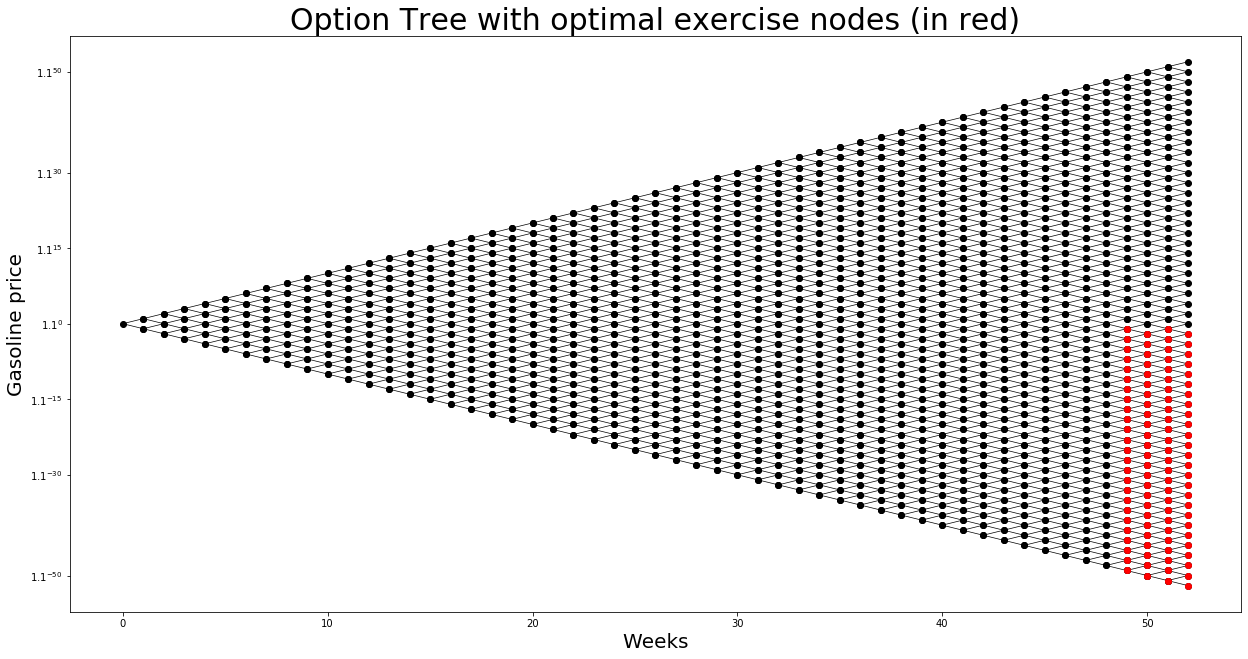

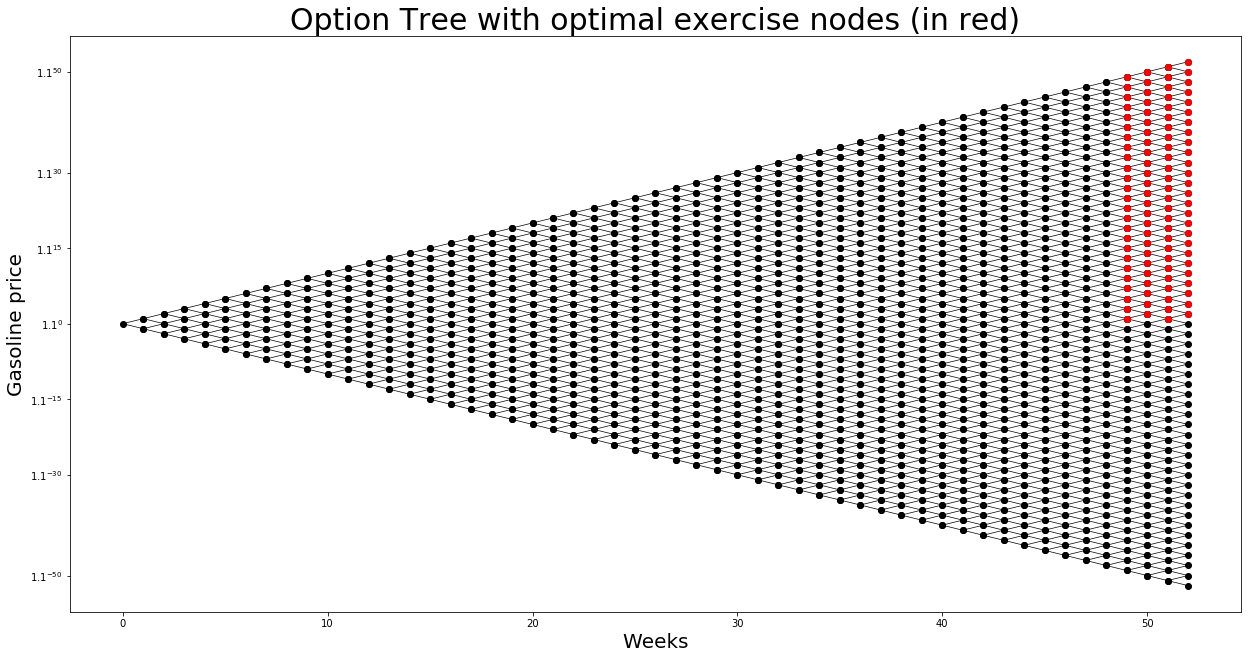

In [504]:
if __name__ == '__main__': 
    main()

0.26759890197818026 0.5351978039563605 0.7977452494943248 1.060292695032289
0.2675989019781813 0.5351978039563626 0.797745249494328 1.060292695032294


0.2675989019781813